<a href="https://colab.research.google.com/github/YoonieJang/CS481/blob/main/Text%20Analytics%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Information

*  Context

Collection of documents and its emotions

*  Example

i feel sick;sadness

*  Goal

When do people use positive emojis when they are texting?

# Import Libraries

In [ ]:
!pip install autocorrect

     |████████████████████████████████| 624kB 11.5MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.5.0-cp37-none-any.whl size=621854 sha256=2976143e15c91131404cc9fcc8cd03ee17b11b5dcad2849762f3854193871973
  Stored in directory: /root/.cache/pip/wheels/1f/71/da/4a15028d25fbd5fb97fb76c5f76f0ad86f0caa69394dd7cfa7
Successfully built autocorrect


In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import mlxtend
import sklearn.cluster as cluster
import sklearn.neighbors
import sklearn.metrics as metrics
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve
from autocorrect import Speller
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load and explore the data
#### The data is available at this source, and you can learn more about how and why this dataset is created from this paper.
Data source: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp 

In [ ]:
uploaded = files.upload()

df = pd.read_csv(io.StringIO(uploaded['emotions.txt'].decode("utf-8")), sep=';')
# the sentiments exist, so that it needs to be separate what emojis are used in each sentence

Saving emotions.txt to emotions.txt


In [ ]:
df.columns=['sentence','emotion']
df.shape, display(df.head())
# we have 17999 sentences for the data and 2 columns for sentence and emotion

,sentence,emotion
0,i can go from feeling so hopeless to so damned...,sadness
1,im grabbing a minute to post i feel greedy wrong,anger
2,i am ever feeling nostalgic about the fireplac...,love
3,i am feeling grouchy,anger
4,ive been feeling a little burdened lately wasn...,sadness


((17999, 2), None)

In [ ]:
df.isnull().sum()

sentence    0
emotion     0
dtype: int64

In [ ]:
df = df.drop_duplicates(keep="first")
df.shape
# compare with the original data 17,998, we removed about 1 duplicate sample

(17998, 2)

In [ ]:
df.tail()

,sentence,emotion
17994,i just keep feeling like someone is being unki...,anger
17995,im feeling a little cranky negative after this...,anger
17996,i feel that i am useful to my people and that ...,joy
17997,im feeling more comfortable with derby i feel ...,joy
17998,i feel all weird when i have to meet w people ...,fear


In [ ]:
# we remoced a sample from data so that do redix
df_reidx = df.reset_index(drop=True)
df_reidx.tail()

,sentence,emotion
17993,i just keep feeling like someone is being unki...,anger
17994,im feeling a little cranky negative after this...,anger
17995,i feel that i am useful to my people and that ...,joy
17996,im feeling more comfortable with derby i feel ...,joy
17997,i feel all weird when i have to meet w people ...,fear


In [ ]:
# convert the emotions to binary labels. love and joy emotions are 1, and sadness, anger, fear, and surprise are 0.
df_reidx['label']=df_reidx['emotion'].replace({'joy':1, 'love': 1, 
                                   'sadness':0, 'anger':0, 'fear':0,'surprise':0})

In [ ]:
# check if pos and neg sentiments
df_reidx.label.value_counts()

0    10479
1     7519
Name: label, dtype: int64

In [ ]:
df_reidx['length'] = df_reidx['sentence'].apply(len) # number of characters
df_reidx['length'].describe() # info()

count    17998.000000
mean        96.823036
std         55.882297
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: length, dtype: float64

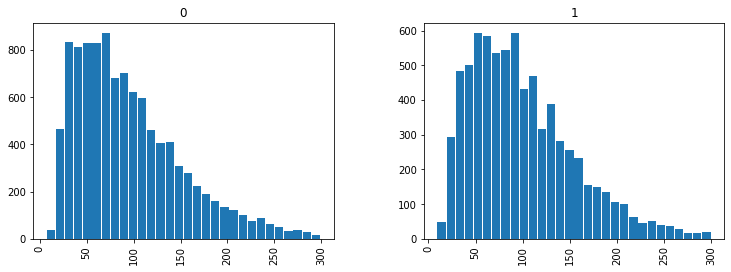

In [ ]:
# plot the distribution of the length of positive and negative emotions
# x: length of reviews; y: number of reviews fall into each interval
df_reidx.hist(column='length', by='label',bins=30, figsize=(12,4),rwidth=0.9)
plt.show()

#### In the plot, there is no significant difference between positive and negative sentences based on the length of the sencetence

In [ ]:
df_reidx

,sentence,emotion,label,length
0,i can go from feeling so hopeless to so damned...,sadness,0,108
1,im grabbing a minute to post i feel greedy wrong,anger,0,48
2,i am ever feeling nostalgic about the fireplac...,love,1,92
3,i am feeling grouchy,anger,0,20
4,ive been feeling a little burdened lately wasn...,sadness,0,65
...,...,...,...,...
17993,i just keep feeling like someone is being unki...,anger,0,163
17994,im feeling a little cranky negative after this...,anger,0,66
17995,i feel that i am useful to my people and that ...,joy,1,85
17996,im feeling more comfortable with derby i feel ...,joy,1,88


# Text Preprocessing
#### To clean the sentences,we do text preprocessing.

*   Decontracted
*   Data cleaning
Additionally,
*   Spell check
*   Lemmatization
*   Nomalization





In [ ]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"wouldnt", "would not", phrase)
    phrase = re.sub(r"shouldnt", "should not", phrase)
    phrase = re.sub(r"couldnt", "could not", phrase)
    phrase = re.sub(r"cudnt", "could not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"dont", "do not", phrase)
    phrase = re.sub(r"doesnt", "does not", phrase)
    phrase = re.sub(r"didnt", "did not", phrase)
    phrase = re.sub(r"wasnt", "was not", phrase)
    phrase = re.sub(r"werent", "were not", phrase)
    phrase = re.sub(r"havent", "have not", phrase)
    phrase = re.sub(r"hadnt", "had not", phrase)

    # general
    phrase = re.sub(r"n\ t", " not", phrase)
    #phrase = re.sub(r"\re", " are", phrase)
    phrase = re.sub(r"\ s ", " is ", phrase) # prime 
    phrase = re.sub(r"\ d ", " would ", phrase)
    phrase = re.sub(r"\ ll ", " will ", phrase)
    phrase = re.sub(r"\dunno", "do not ", phrase)
    phrase = re.sub(r"ive ", "i have ", phrase)
    phrase = re.sub(r"im ", "i am ", phrase)
    phrase = re.sub(r"i m ", "i am ", phrase)
    phrase = re.sub(r" w ", " with ", phrase)
    
    return phrase

    
def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['sentence']):
        
        # expand the contracted words
        review_text = decontracted(review_text)
        
        #remove html tags
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #remove url 
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review  

def spellcheck(df_reidx):
  spell = Speller(lang='en')
  spellchecked_text = []

  for review_text in tqdm(df_reidx['cleaned_sentence']):
    # expand the contracted words
    review_text = spell(review_text)
    spellchecked_text.append(review_text)

  return spellchecked_text


df_reidx['cleaned_sentence'] = clean_text(df_reidx)
#df_reidx['cleaned_sentence'] = spellcheck(df_reidx) 


# df_data['cleaned_review'] = df_data.apply(clean_text)
# df_data = df_data.drop(columns=['review'])

df_reidx.head()  

100%|██████████| 17998/17998 [00:04<00:00, 3675.97it/s]


,sentence,emotion,label,length,cleaned_sentence
0,i can go from feeling so hopeless to so damned...,sadness,0,108,i can go from feeling so hopeless to so damned...
1,im grabbing a minute to post i feel greedy wrong,anger,0,48,i am grabbing a minute to post i feel greedy w...
2,i am ever feeling nostalgic about the fireplac...,love,1,92,i am ever feeling nostalgic about the fireplac...
3,i am feeling grouchy,anger,0,20,i am feeling grouchy
4,ive been feeling a little burdened lately wasn...,sadness,0,65,i have been feeling a little burdened lately w...


###### additional lemmatization

In [ ]:
def lemmatization(df_reidx):
  lemmatizer = WordNetLemmatizer()
  lemmatized_output=[]

  for review_text in tqdm(df_reidx['cleaned_sentence']):

    review_text = lemmatizer.lemmatize(review_text)
    lemmatized_output.append(review_text)

  return lemmatized_output
df_reidx['cleaned_sentence'] = lemmatization(df_reidx) 

100%|██████████| 17998/17998 [00:00<00:00, 195546.80it/s]


In [ ]:
# example of a sentence before and after cleaning, we can see that the punctuations and html tags are removed.
print(df_reidx['sentence'][177],'\n')

print(df_reidx['cleaned_sentence'][177])

ive lost some weight such that i could fit into a tiny skirt that ive been unable to wear because i didnt feel confident in it until now 

i have lost some weight such that i could fit into a tiny skirt that i have been unable to wear because i did not feel confident in it until now


# Feature Engineering

### CounterVectorize: tokenization: 

In [ ]:
# convert the cleaned sentences to vectors
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
# a built-in stop word list for english is used
# all values of n such than min_n<=n<= max_n will be used. (1,1): only unigrams, (1,2):uni&bigram, (2,2): only bigrams
# max_df: when building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold.
# min_df: ignore terms that have a document frequency strictly lower than the given threshold.

vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=3, ngram_range=(1,1),tokenizer = token.tokenize)
x = vectorizer.fit_transform(df_reidx.cleaned_sentence)
y = df_reidx.label.values

print("X.shape : ",x.shape)
print("y.shape : ",y.shape)

X.shape :  (17998, 5341)
y.shape :  (17998,)


# Train Test split

```
# This is formatted as code
```



In [ ]:
# do shuffle to make neg and pos data of data set split equaly in the test and training set
# do random_sate for making it settle when we run this code repeatedly
train_idx, test_idx = train_test_split(np.arange(df_reidx.shape[0]), test_size=0.3,shuffle=True, random_state=42)

x_train = x[train_idx]
y_train = y[train_idx]

x_test = x[test_idx]
y_test = y[test_idx]
print("Number of training examples:{}".format(len(train_idx)))
print("Number of testing examples:{}\n".format(len(test_idx)))
print("Training data: X_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(x_test.shape, y_test.shape))


Number of training examples:12598
Number of testing examples:5400

Training data: X_train : (12598, 5341), y_train : (12598,)
Testing data: X_test : (5400, 5341), y_test : (5400,)


# Model Training

#### Logistic Regression

In [ ]:
# fit a logistic regression classifier on the training data use default settings
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)

# make prediction on testing data
y_pred_test_lr = lr_clf.predict(x_test)
y_predprob_lr = lr_clf.predict_proba(x_test)
matrix_lr = confusion_matrix(y_test,y_pred_test_lr)
print(matrix_lr)

[[3045   86]
 [ 121 2148]]


In [ ]:
print(classification_report(y_test, y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3131
           1       0.96      0.95      0.95      2269

    accuracy                           0.96      5400
   macro avg       0.96      0.96      0.96      5400
weighted avg       0.96      0.96      0.96      5400



In [ ]:
print("Accuracy for Bernouli Naive Bayes model:",metrics.accuracy_score(y_test, y_pred_test_lr))

Accuracy for Bernouli Naive Bayes model: 0.9616666666666667


#### Naive Bayes classifier

##### BernouliNB

A binary algorithm used when the feature is present or not.

In [ ]:
from sklearn.naive_bayes import BernoulliNB
nb_clf = BernoulliNB()
nb_clf.fit(x_train, y_train)
# make prediction on testing data
y_pred_test_nb = nb_clf.predict(x_test)
y_predprob_nb = nb_clf.predict_proba(x_test)
matrix_nb = confusion_matrix(y_test,y_pred_test_nb)
print(matrix_nb)

[[2989  142]
 [ 203 2066]]


In [ ]:
y_pred_test_nb

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
y_predprob_test_nb = nb_clf.predict_proba(x_test)
y_predprob_test_nb

array([[0.98454182, 0.01545818],
       [0.98288329, 0.01711671],
       [0.9797263 , 0.0202737 ],
       ...,
       [0.61684528, 0.38315472],
       [0.34840819, 0.65159181],
       [0.99529108, 0.00470892]])

In [ ]:
print(classification_report(y_test, y_pred_test_nb))
# micro average (averaging the total true positives, false negatives and false positives globally, true pos of one class / (all true pos + all false pos))
# macro average (averaging the unweighted mean per label)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3131
           1       0.92      0.90      0.91      2269

    accuracy                           0.93      5400
   macro avg       0.93      0.92      0.93      5400
weighted avg       0.93      0.93      0.93      5400



In [ ]:
from sklearn import metrics
print("Accuracy for Bernouli Naive Bayes model:",metrics.accuracy_score(y_test, y_pred_test_nb))

Accuracy for Bernouli Naive Bayes model: 0.9361111111111111


##### MultinominaliNB

It consider a feature vector where a given term represents the number of times it appears or very ofen, such as frequency.

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
# make prediction on testing data
y_pred_test_mnb = mnb.predict(x_test)
y_predprob_mnb = mnb.predict_proba(x_test)
matrix = confusion_matrix(y_test,y_pred_test_mnb)
print(matrix)

[[2989  142]
 [ 193 2076]]


In [ ]:
print(classification_report(y_test, y_pred_test_mnb))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3131
           1       0.94      0.91      0.93      2269

    accuracy                           0.94      5400
   macro avg       0.94      0.93      0.94      5400
weighted avg       0.94      0.94      0.94      5400



In [ ]:
print("Accuracy for multinominal Naive Bayes model:",metrics.accuracy_score(y_test, y_pred_test_mnb))

Accuracy for multinominal Naive Bayes model: 0.937962962962963


# Model Evaluation

# Cross validataion

##### Logistic Regression

In [ ]:
# n-fold cross validation
scores_lr = cross_val_score(lr_clf, x, y, cv=5, scoring='precision')
print(scores_lr)

[0.96563342 0.96551724 0.95515395 0.95681063 0.96392786]


##### BernouliNB

In [ ]:
scores_nb = cross_val_score(nb_clf, x, y, cv=5, scoring='precision')
print(scores_nb)

[0.94121622 0.93924915 0.93877551 0.93847194 0.93914807]


##### MultinominaliNB

In [ ]:
scores_mnb = cross_val_score(mnb, x, y, cv=5, scoring='precision')
print(scores_mnb)

[0.94395679 0.94455852 0.9375     0.94372881 0.9459094 ]


##### ROC Curve

##### Logistic Regression

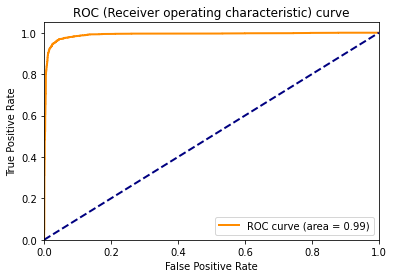

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_predprob_lr[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

##### BernouliNB

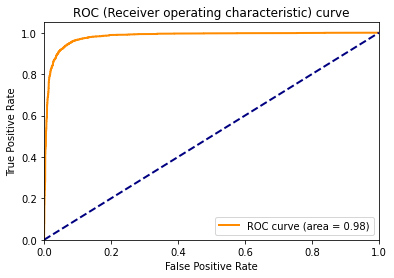

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_predprob_nb[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

##### MultinominaliNB

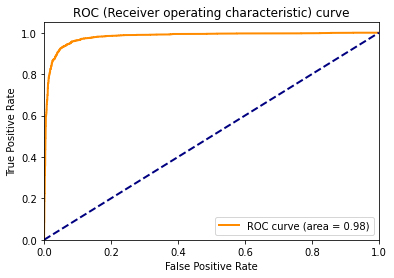

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_predprob_mnb[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

### Precision Recall Curve

##### Logistic Regression

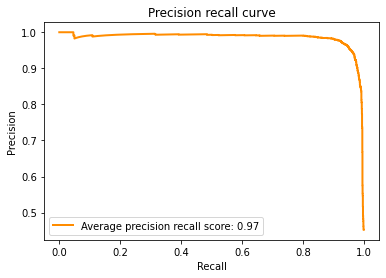

In [ ]:
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_predprob_lr[:,1], pos_label=1)
plt.plot(recall, precision, color='darkorange', lw=lw, label='Average precision recall score: %0.2f' % average_precision_score(y_test, y_predprob_mnb[:,1]))

plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

##### BernouliNB

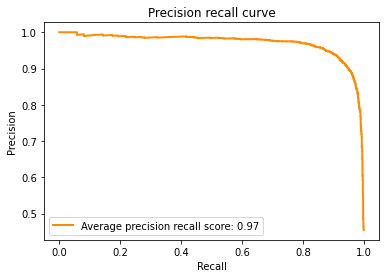

In [ ]:
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_predprob_nb[:,1], pos_label=1)
plt.plot(recall, precision, color='darkorange', lw=lw, label='Average precision recall score: %0.2f' % average_precision_score(y_test, y_predprob_mnb[:,1]))

plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

##### MultinominaliNB

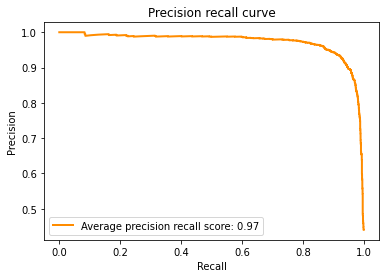

In [ ]:
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_predprob_mnb[:,1], pos_label=1)
plt.plot(recall, precision, color='darkorange', lw=lw, label='Average precision recall score: %0.2f' % average_precision_score(y_test, y_predprob_mnb[:,1]))

plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

###### LinearRegression

In [ ]:
acc_score_lr = metrics.accuracy_score(y_pred_test_lr,y_test)
prec_score_lr = precision_score(y_test,y_pred_test_lr, average='macro')
recall_lr = recall_score(y_test, y_pred_test_lr,average='macro')
f1_lr = f1_score(y_test,y_pred_test_nb,average='macro')
matrix_lr = confusion_matrix(y_test,y_pred_test_lr)
print('Logistic Regression Model\n')
print(str('Accuracy: '+'{:04.2f}'.format(acc_score_lr*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score_lr*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall_lr*100))+'%')
print('F1 Score: ',f1_lr)
print(matrix_lr)

Logistic Regression Model

Accuracy: 96.17%
Precision: 96.16%
Recall: 95.96%
F1 Score:  0.9341883804092479
[[3045   86]
 [ 121 2148]]


##### BernouliNB

In [ ]:
acc_score_nb = metrics.accuracy_score(y_pred_test_nb,y_test)
prec_score_nb = precision_score(y_test,y_pred_test_nb, average='macro')
recall_nb = recall_score(y_test, y_pred_test_nb,average='macro')
f1_nb = f1_score(y_test,y_pred_test_nb,average='macro')
matrix_nb = confusion_matrix(y_test,y_pred_test_nb)
print('Bernouli Naive Bayes Model\n')
print(str('Accuracy: '+'{:04.2f}'.format(acc_score_nb*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score_nb*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall_nb*100))+'%')
print('F1 Score: ',f1_nb)
print(matrix_nb)

Bernouli Naive Bayes Model

Accuracy: 93.61%
Precision: 93.60%
Recall: 93.26%
F1 Score:  0.9341883804092479
[[2989  142]
 [ 203 2066]]


##### MultinominaliNB

In [ ]:
acc_score_mnb = metrics.accuracy_score(y_pred_test_mnb,y_test)
prec_score_mnb = precision_score(y_test,y_pred_test_mnb, average='macro')
recall_mnb = recall_score(y_test, y_pred_test_mnb,average='macro')
f1_mnb = f1_score(y_test,y_pred_test_mnb,average='macro')
matrix_mnb = confusion_matrix(y_test,y_pred_test_mnb)
print('Multimominal Naive Bayes Model\n')
print(str('Accuracy: '+'{:04.2f}'.format(acc_score_mnb*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score_mnb*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall_mnb*100))+'%')
print('F1 Score: ',f1_mnb)
print(matrix_mnb)

Multimominal Naive Bayes Model

Accuracy: 93.80%
Precision: 93.77%
Recall: 93.48%
F1 Score:  0.9361373834917643
[[2989  142]
 [ 193 2076]]


# Grid Search for parameter tuning

##### Logistic Regression parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

vector = CountVectorizer(stop_words='english')
logistic = LogisticRegression() # , tol=0.1

# build a pipeline
pipe = Pipeline(steps = [
       ('vectorizer', vector),
       ('classifier', logistic)])

# creat a dictionary of model parameters and corresponding values
# For example, in countvectorizer, we want to explore the suitable value for min_df, select from 1,3,5,10
param_grid = {
    'vectorizer__min_df': [1, 3, 5, 10],
    'vectorizer__max_df': [0.7, 0.8, 0.9],
    'classifier__penalty': ['l1','l2']}

# run GridSearchCV, cv, f1
search_result = GridSearchCV(pipe, param_grid, cv=5, scoring='f1').fit(df_reidx.cleaned_sentence.values, df_reidx.label.values)


print("Best parameter (CV score=%0.3f):" % search_result.best_score_) # scoring: accuracy by default
print(search_result.best_params_)
# with 5 fold cv, the best f1 score is 0.958, and the corresponding parameter values are as follows:

Best parameter (CV score=0.958):
{'classifier__penalty': 'l2', 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 3}


##### Bernoulli Naive Bayes parameter tuning

In [ ]:
vector = CountVectorizer(stop_words='english')
logistic = BernoulliNB() # , tol=0.1

# build a pipeline
pipe = Pipeline(steps = [
       ('vectorizer', vector),
       ('classifier', logistic)])
parameters = {'vectorizer__min_df': [1, 3, 5, 10],
    'vectorizer__max_df': [0.7, 0.8, 0.9],
    'classifier__alpha':[0.0, 0.1, 1.0, 2.0, 10.0]}

# run GridSearchCV, cv, f1    
search_result = GridSearchCV(pipe, parameters, cv=5, scoring='f1').fit(df_reidx.cleaned_sentence.values, df_reidx.label.values)

print("Best parameter (CV score=%0.3f):" % search_result.best_score_) 
print(search_result.best_params_)
# with 5 fold cv, the best f1 score is 0.943, and the corresponding parameter values are as follows:

Best parameter (CV score=0.943):
{'classifier__alpha': 0.0, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 10}


##### Multinomial Naive Bayes parameter tuning

In [ ]:
vector = CountVectorizer(stop_words='english')
logistic = MultinomialNB() # , tol=0.1

# build a pipeline
pipe = Pipeline(steps = [
       ('vectorizer', vector),
       ('classifier', logistic)])
parameters = {'vectorizer__min_df': [1, 3, 5, 10],
    'vectorizer__max_df': [0.7, 0.8, 0.9],
    'classifier__alpha':[0.0, 0.1, 1.0, 2.0, 10.0]}

# run GridSearchCV, cv, f1    
search_result = GridSearchCV(pipe, parameters, cv=5, scoring='f1').fit(df_reidx.cleaned_sentence.values, df_reidx.label.values)

print("Best parameter (CV score=%0.3f):" % search_result.best_score_) 
print(search_result.best_params_)
# with 5 fold cv, the best f1 score is 0.942, and the corresponding parameter values are as follows:

Best parameter (CV score=0.942):
{'classifier__alpha': 1.0, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 5}


# Explain the model prediction

Multimominal Naive Bayes Model has higher accuracy than Bernouli Naive Bayes Model. And Logistic Regression model has the highest accuracy than others, so I chose Logistic Regression model to test the model.

In [ ]:
test_data = df_reidx.iloc[test_idx]
test_data['pred_label'] = y_pred_test_lr
test_data.head(2)[['sentence','label','pred_label']]
# shows what the prediction label fit to the real label

,sentence,label,pred_label
11364,i feel i was wronged,0,0
4119,i feel tortured when i hear them talk or sing ...,0,0


In [ ]:
# shows what the prediction label does not fit to the real label
test_data[test_data['label'] != test_data['pred_label']].head()[['sentence','label','pred_label']].head(2)

,sentence,label,pred_label
290,i feel excelent but sometimes theres just noth...,1,0
5725,i think he was feeling fond of and possessive ...,1,0


##### Predicted features of logistic regression model

In [ ]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('supporting', 3.384),
 ('accepted', 3.378),
 ('generous', 3.325),
 ('sympathetic', 3.282),
 ('satisfied', 3.261),
 ('faithful', 3.216),
 ('passionate', 3.212),
 ('pleasant', 3.17),
 ('respected', 3.118),
 ('superior', 3.111)]

In [ ]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('pressured', -3.142),
 ('hated', -3.008),
 ('agitated', -2.831),
 ('punished', -2.825),
 ('groggy', -2.813),
 ('reluctant', -2.769),
 ('tortured', -2.763),
 ('intimidated', -2.748),
 ('amazed', -2.727),
 ('dangerous', -2.682)]

##### Predicted features of BernouliNB

In [ ]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), nb_clf.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('feeling', -1.261),
 ('like', -1.708),
 ('nothe', -2.519),
 ('just', -2.577),
 ('really', -2.89),
 ('time', -3.037),
 ('know', -3.09),
 ('did', -3.219),
 ('make', -3.248),
 ('love', -3.273)]

In [ ]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('aa', -8.566),
 ('abide', -8.566),
 ('abit', -8.566),
 ('abuse', -8.566),
 ('academic', -8.566),
 ('accident', -8.566),
 ('accomplishments', -8.566),
 ('according', -8.566),
 ('account', -8.566),
 ('accustomed', -8.566)]

##### Predicted features of multinomial NB

In [ ]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), mnb.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('feeling', -3.33),
 ('like', -3.724),
 ('nothe', -4.563),
 ('just', -4.625),
 ('really', -4.917),
 ('time', -5.058),
 ('know', -5.118),
 ('love', -5.234),
 ('did', -5.256),
 ('make', -5.293)]

In [ ]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('aa', -10.663),
 ('abide', -10.663),
 ('abit', -10.663),
 ('abuse', -10.663),
 ('academic', -10.663),
 ('accident', -10.663),
 ('accomplishments', -10.663),
 ('according', -10.663),
 ('account', -10.663),
 ('accustomed', -10.663)]

# Conclusion

In [ ]:
text=['i want to make this positive', 'i want to make this project better', 'i feel aaaaaaah']
test_result = lr_clf.predict(vectorizer.transform(text))
print(test_result)

[1 1 0]


The multinominal Naive Bayes model is slightly higher than Bernoulli Naive Bayes model.
Using the Logistic Regression model is the best model along with the three classifiers because it has the highest accuracy through this project. Also, the predicted features of the logistic regression model are most accurate and reasonable compare to other classifiers. By comparing the three classifiers, the logistic regression model has three to four higher accuracy than others.

According to the Logistic Regression Model prediction, when people talk about their feeling that they are accepted, supported, and beloved, they use positive emojis when they are texting. On the other hand, when people feel pressured, hated, or punished, they use negative emojis when texting. 
